# Metadata

```
Course:   DS 5001
Module:   12 Lab
Topic:    Sentiment and Plot in Novels
Author:   R.C. Alvarado

Purpose:  Visualize plot sentiment as signal.
```

# Set Up

In [27]:
data_home = "../data"

In [41]:
OHCO = ['book_id', 'chap_id','para_num','sent_num']
sent_cols = ['nrc_polarity','syu_sentiment','gi_sentiment', 'bing_sentiment']
emo_cols = "nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
import scipy as sp
import scipy.fftpack as fftpack

In [31]:
sns.set()

# Get CORPUS

Get the corpus of books bagged by sentence.

In [32]:
CORPUS = pd.read_csv(f"{data_home}/combo/combo-sentence-sentiment.csv").set_index(OHCO).sort_index()

In [33]:
CORPUS.head()

bing_positive  bing_negative  \
book_id    chap_id para_num sent_num                                 
adventures 1       0        1                   0.0           0.25   
                   1        0                   0.0           0.00   
                   2        0                   0.0           0.00   
                            1                   0.0           0.00   
                            2                   0.0           0.00   

                                      bing_sentiment  nrc_anger  \
book_id    chap_id para_num sent_num                              
adventures 1       0        1                  -0.25        0.0   
                   1        0                   0.00        0.0   
                   2        0                   0.00        0.0   
                            1                   0.00        0.0   
                            2                   0.00        0.0   

                                      nrc_anticipation  nrc_disgust  nrc_fear  \
book_id    chap_id para_num sent_num                                            
adventures 1       0        1                 0.000000          0.0      0.25   
                   1        0                 0.000000          0.0      0.00   
                   2        0                 0.000000          0.0      0.00   
                            1                 0.000000          0.0      0.00   
                            2                 0.083333          0.0      0.00   

                                       nrc_joy  nrc_negative  nrc_positive  \
book_id    chap_id para_num sent_num                                         
adventures 1       0        1         0.000000          0.25      0.000000   
                   1        0         0.000000          0.00      0.000000   
                   2        0         0.000000          0.00      0.000000   
                            1         0.000000          0.00      0.000000   
                            2         0.083333          0.00      0.083333   

                                      nrc_sadness  nrc_surprise  nrc_trust  \
book_id    chap_id para_num sent_num                                         
adventures 1       0        1                 0.0           0.0   0.000000   
                   1        0                 0.0           0.0   0.000000   
                   2        0                 0.0           0.0   0.000000   
                            1                 0.0           0.0   0.000000   
                            2                 0.0           0.0   0.083333   

                                      nrc_polarity  syu_sentiment  \
book_id    chap_id para_num sent_num                                
adventures 1       0        1            -0.250000      -0.250000   
                   1        0             0.000000       0.000000   
                   2        0             0.000000       0.000000   
                            1             0.000000       0.000000   
                            2             0.083333       0.008333   

                                      gi_sentiment  labmt_happiness  
book_id    chap_id para_num sent_num                                 
adventures 1       0        1                -0.25         3.480000  
                   1        0                 0.00         5.920000  
                   2        0                 0.00         5.015000  
                            1                 0.00         5.362727  
                            2                 0.00         4.815000

## Visualize Raw Sentiment Signals

In [120]:
def visualize_raw(book_title, BOOK, axes=None, col=1):
        
    for i, col_name in enumerate(BOOK.columns):
        ax = axes[i, col]
        plot_title = book_title + ': ' + col_name + ' (raw)'
        BOOK[col_name].plot(ax=ax);
        ax.set_title(plot_title, fontsize=18)
        ax.set_xlabel('')


## Jockers' original FFT function

**Jockers' original FFT function params**

<table>
    <tr><td>raw_values</td><td>the raw sentiment values calculated for each sentence</td></tr>
    <tr><td>low_pass_size</td><td>The number of components to retain in the low pass filtering. Default = 3</td></tr>
    <tr><td>x_reverse_len</td><td>the number of values to return. Default = 100</td></tr>
    <tr><td>padding_factor</td><td>the amount of zero values to pad raw_values with, as a factor of the size of raw_values. Default = 2.</td></tr>
    <tr><td>scale_vals</td><td>Logical determines whether or not to normalize the values using the scale function Default = FALSE. If TRUE, values will be scaled by subtracting the means and scaled by dividing by their standard deviations. See ?scale</td></tr>
    <tr><td>scale_range</td><td>Logical determines whether or not to scale the values from -1 to +1. Default = FALSE. If set to TRUE, the lowest value in the vector will be set to -1 and the highest values set to +1 and all the values scaled accordingly in between.</td></tr>
</table>    

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [63]:
def get_transformed_values(raw_values, 
                           low_pass_size=3, 
                           x_reverse_len=100,  
                           padding_factor=2, 
                           scale_values=False, 
                           scale_range=False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

    transformed_values = np.real(tuple(inverse_values))
    return transformed_values

## Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [64]:
def get_dct_transform(raw_values, 
                      low_pass_size=5, 
                      x_reverse_len=100,
                      dct_type=3):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = dct_type) # 2 or 3 works well
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return dct_out

## Visualization FFT or DCT

In [121]:
def visualize_smooth(book_title, BOOK, dct=True, low_pass_size=5, x_reverse_len=100, axes=None, col=1):

    S_methods = BOOK.columns.tolist()
    
    for i, S_method in enumerate(S_methods):
        
        ax = axes[i, col]
        
        X = BOOK[S_method].values
        
        if dct:
            method="DCT"
            X = get_dct_transform(X, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len)
        else:
            method="FFT"
            X = get_transformed_values(X, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len, padding_factor = 1)
        
        # Scale Range
        X = (X - X.mean()) / X.std()

        plot_title = "{}: {} ({})".format(book_title, S_method, method)

        pd.Series(X).plot(ax=ax);
        ax.set_title(plot_title, fontsize=18) # title of plot

    # plt.tight_layout()

## Do it all

In [131]:
def plotitall(book_id, norm=None):
    global CORPUS
    
    BOOK = CORPUS.loc[book_id][sent_cols]
    
    fig, axes = plt.subplots(
        nrows=len(BOOK.columns), 
        ncols=3, 
        figsize=(25, 3 * len(sent_cols) * 1),
        sharex='col', 
        sharey=True #'row'
    )
    plt.tight_layout()

    visualize_raw(book_id, BOOK, axes=axes, col=0)
    visualize_smooth(book_id, BOOK, dct=False, low_pass_size=3, axes=axes, col=1)
    visualize_smooth(book_id, BOOK, dct=True, low_pass_size=5, axes=axes, col=2)

# Explore 

## Northanger Abbey

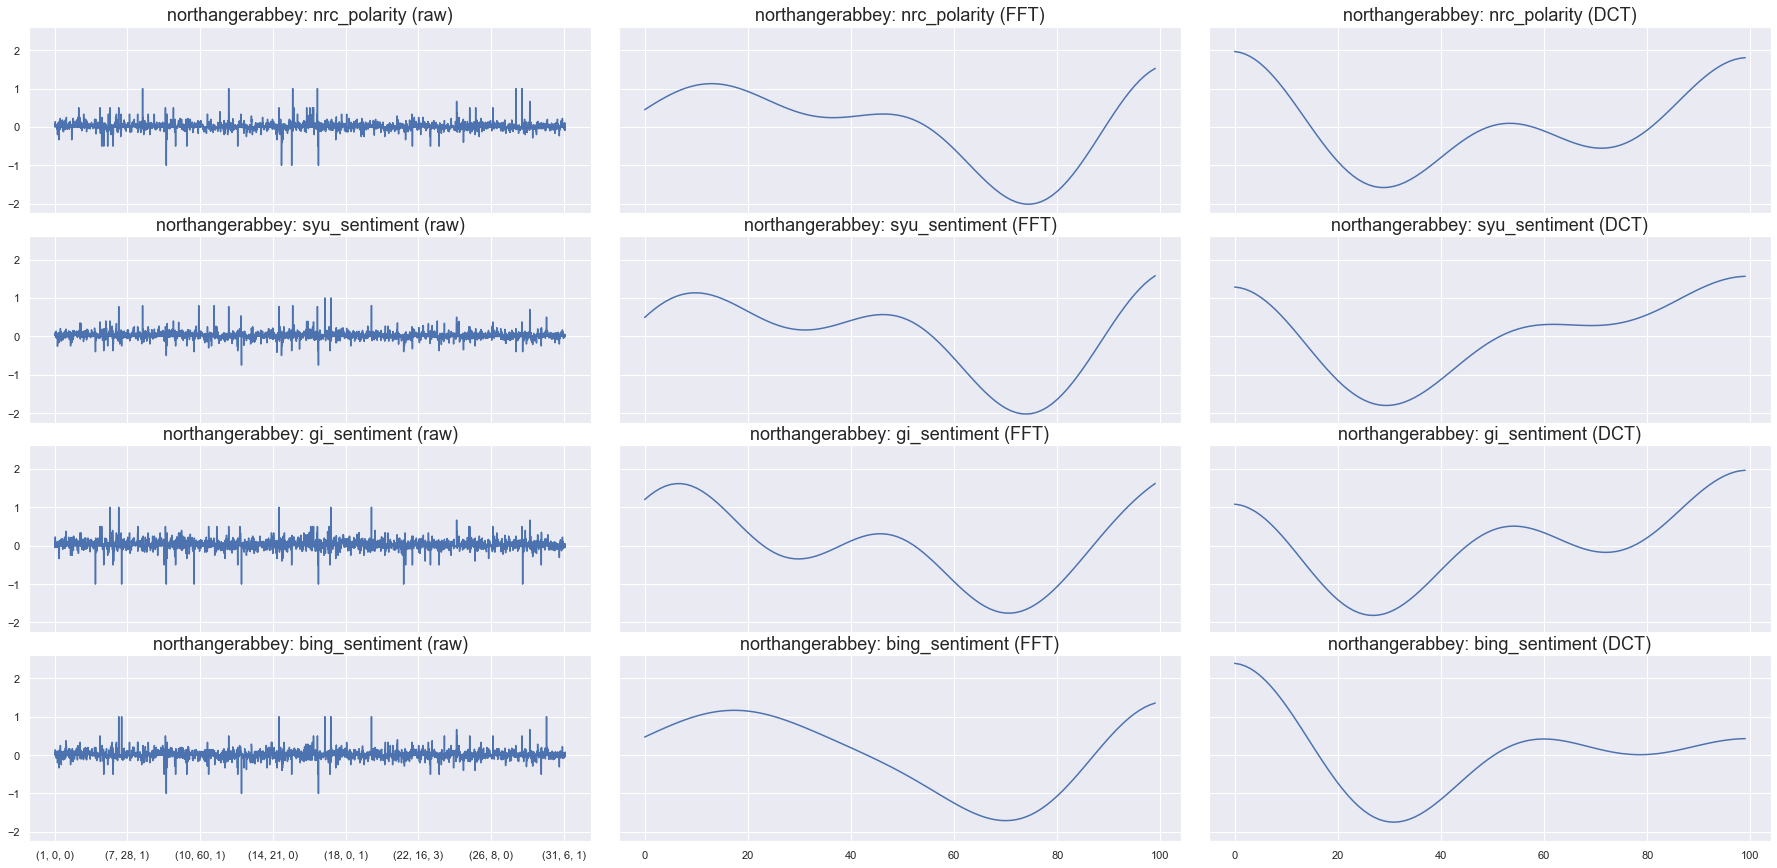

In [132]:
plotitall('northangerabbey')

## Frankenstein

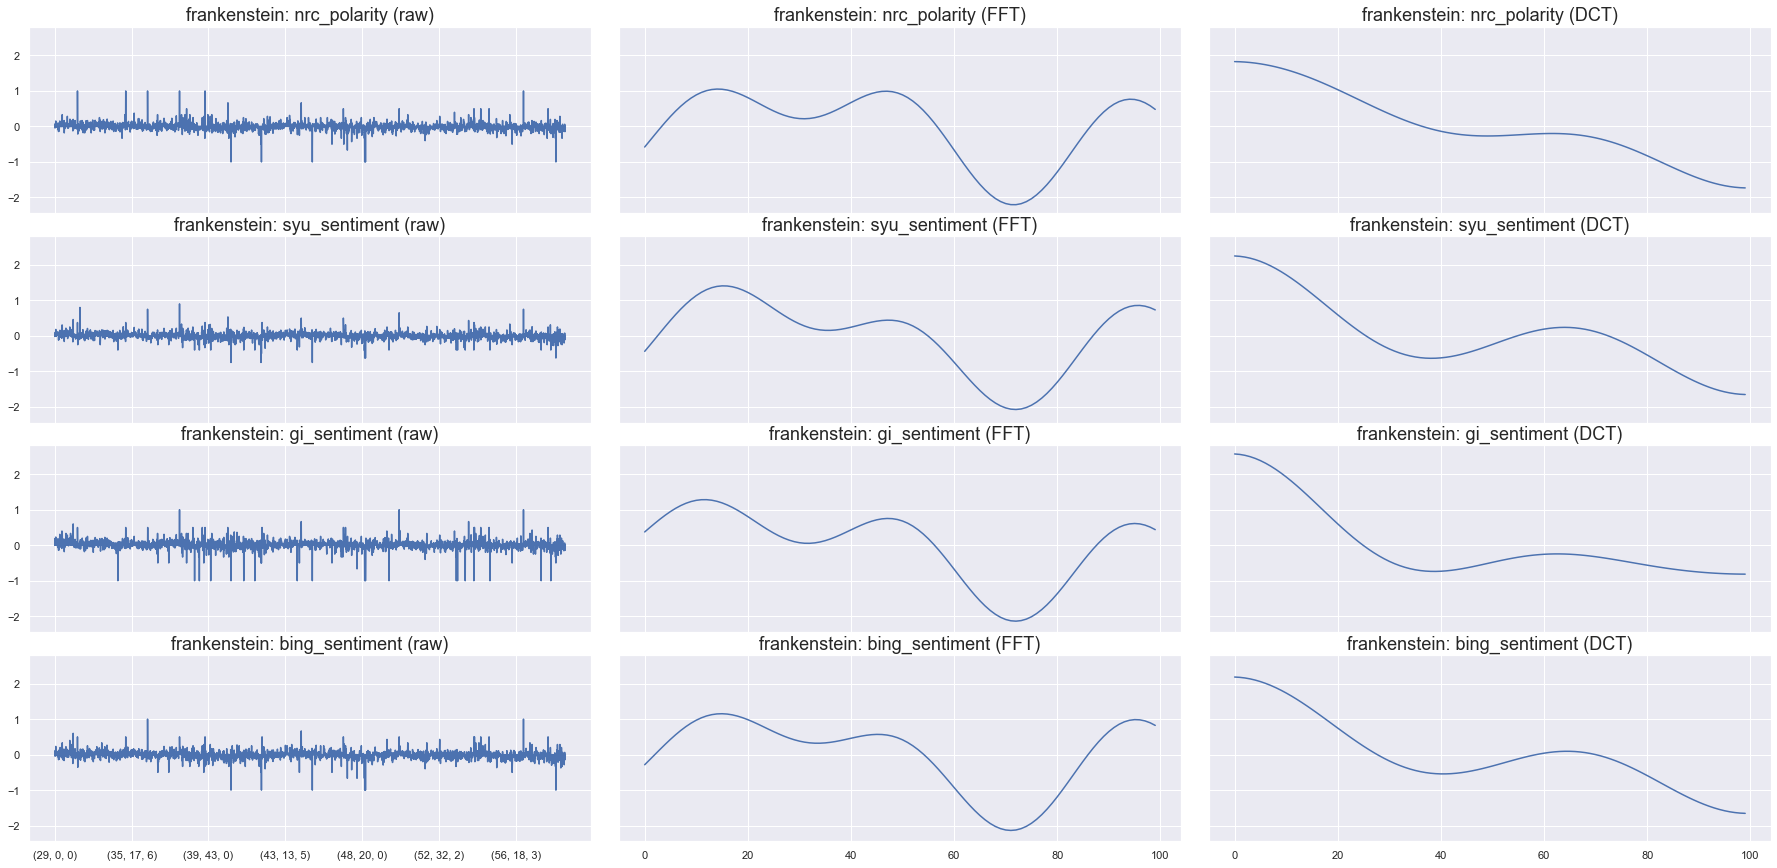

In [133]:
plotitall('frankenstein')

## Dracula

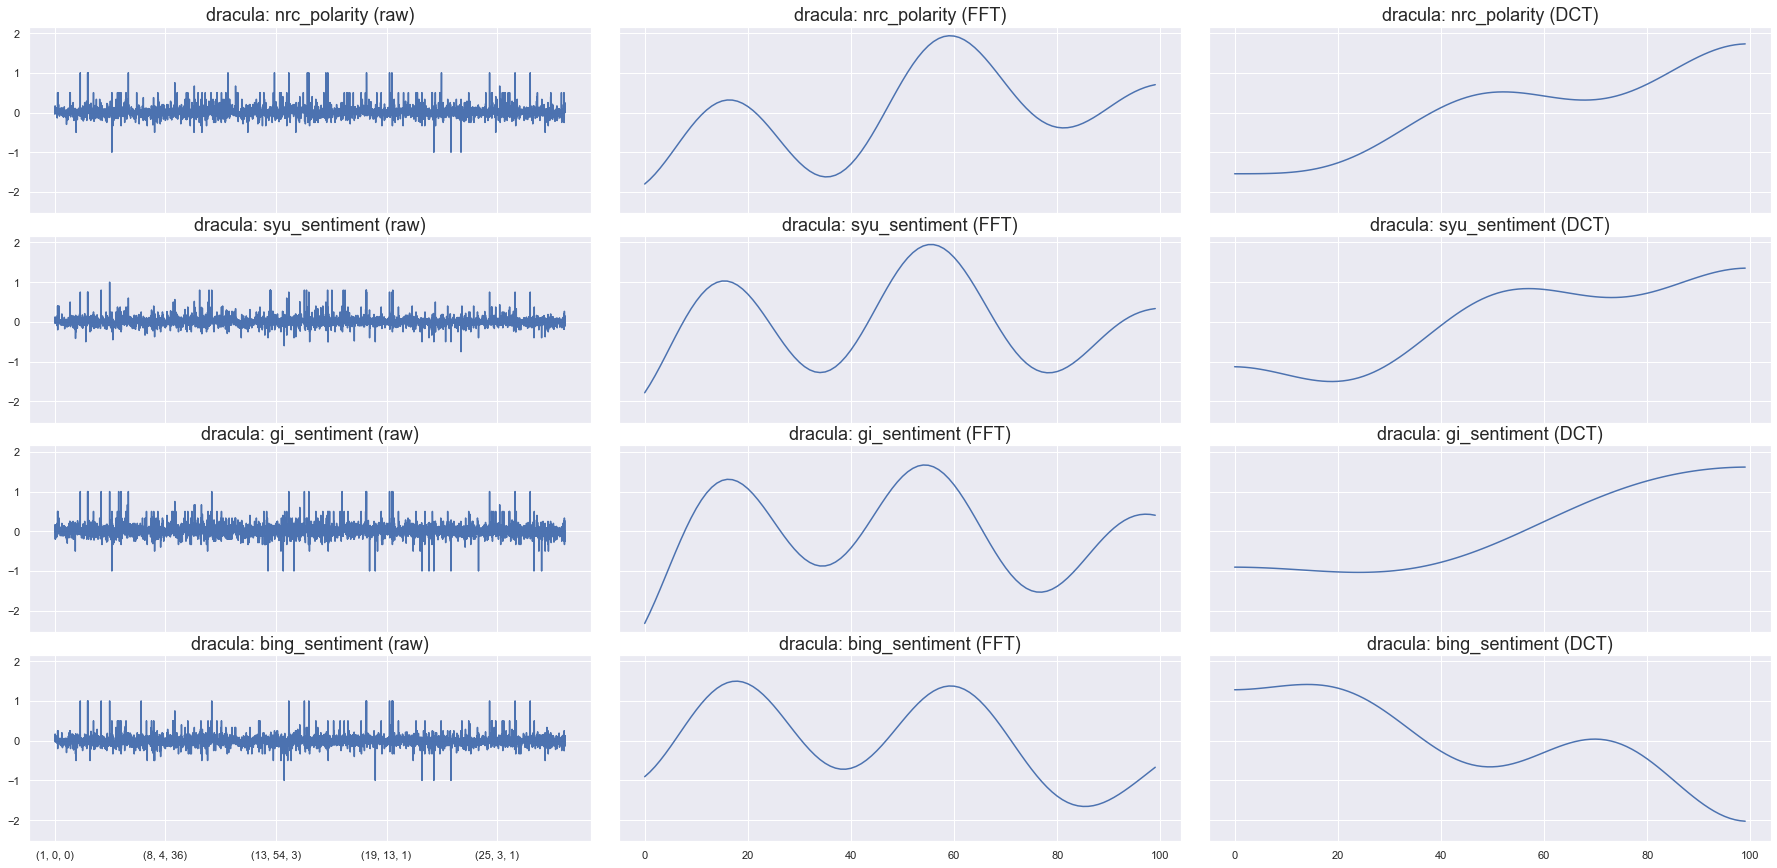

In [134]:
plotitall('dracula')

# Picking the Right Hyperparameters

* Smoothing function = `DCT`
* DCT type = `3`
* Sentiment function = `syu_sentiment` or `nrc_polarity`? -- See *Dracula* when DCT type = 3
* Sentiment norming = `None`

## Function to visualize single feature

In [141]:
def visualize_single(book_id, 
                     sent_col = 'nrc_polarity',
                     low_pass_size=5, 
                     x_reverse_len=100, 
                     dct_type=3,
                     norm=None
                    ):
    global CORPUS
    book_title = book_id # LIB.loc[book_id].title
    BOOK = CORPUS.loc[book_id] # compute_sentiment(book_id, norm=norm)

    X = BOOK[sent_col].values
    X = get_dct_transform(X, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len, dct_type=dct_type)
    X = (X - X.mean()) / X.std()

    plot_title = f"{book_title}: {sent_col} (DCT)"
    ax = pd.Series(X).plot(figsize=(10, 3), legend=False, fontsize=16);
    ax.set_title(plot_title, fontsize=20)
    plt.tight_layout()

## Northanger Abbey

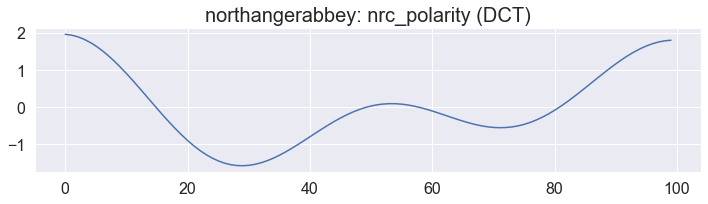

In [142]:
visualize_single('northangerabbey')

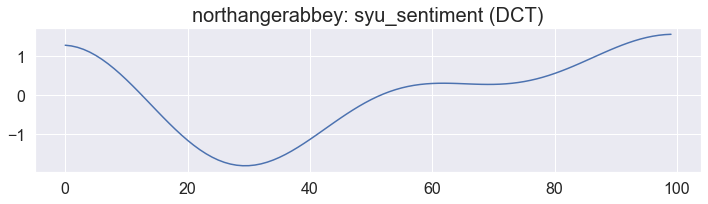

In [143]:
visualize_single('northangerabbey', 'syu_sentiment')

**Federalist**:
> In the end, the two are wed. In the final pages of “Northanger Abbey,” Austen writes that the couple was brought together through mutual affection and that Henry Tinley’s affection for Catherine is rooted in gratitude for her feelings for him. **She’s implying that the typically overwrought and dramatic type of romance on display in most fictitious works does not hold a candle to real love that is rooted in a commitment to one’s husband or wife.** Happy endings and “perfect happiness” are often brought about through ordinary and conventional means — means that ought not to be dismissed because they are **less sexy** than the conventions used in a Gothic novel. \
https://thefederalist.com/2018/10/09/jane-austen-pulled-off-feat-genius-northanger-abbey/

**Schmoop**:

>Northanger Abbey has **a very neat and tidy and rather clichéd ending**: all the nice main characters get married to other nice characters and live happily ever after. All the mean characters end up alone. It's like a Disney movie.\
\
Aside from being rather predictable, **this ending is also a little weird**. What's odd about this ending is that the entire novel spends a lot of time undermining the various clichés of popular Gothic novels. But it ends with a series of giant clichés, including a deus ex machina, which is a fancy Latin term meaning a convenient plot element that is dropped in out of nowhere. The deus ex machina here is that one of the nice and long suffering characters happens to marry a wealthy Viscount who has never before been mentioned. It's completely random. And the narrator even admits that this is pretty weird and random. \
\
The novel's ending isn't just clichéd, **it's totally over-the-top clichéd**. So, rather than being out of step with the rest of the book, the ending actually bumps the satire up a notch and goes for broke. Like the rest of the book, the ending is still highly satirical – **it exaggerates and mocks the types of sentimental and even ludicrous endings often found in Gothic novels**. The ending just accomplishes the satire in a different way than the rest of the book, which relies more on clever dialogue and humorously disrupted expectations. Instead of letting the characters supply the humor through their words and actions, the ending utilizes outrageous plot devices and ironic narrative commentary. Still, why Jane Austen decided to go with an over-the-top ending instead of a more subtle ending is debatable.\
https://www.shmoop.com/study-guides/literature/northanger-abbey/analysis/ending

## Frankenstein

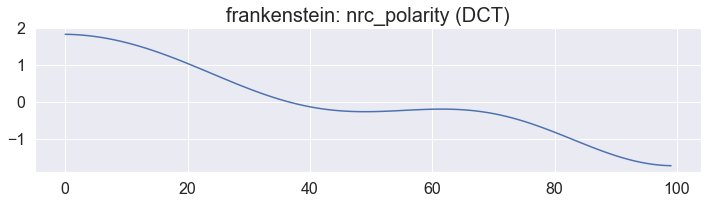

In [144]:
visualize_single('frankenstein')

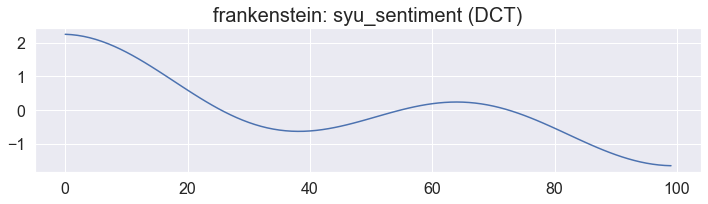

In [145]:
visualize_single('frankenstein', 'syu_sentiment')

## Dracula

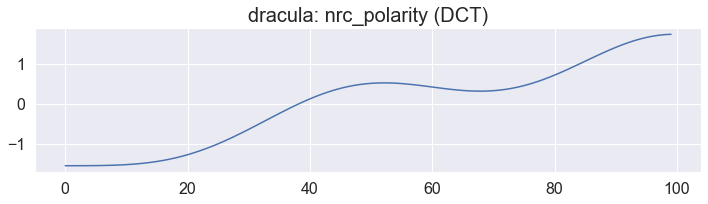

In [146]:
visualize_single('dracula')

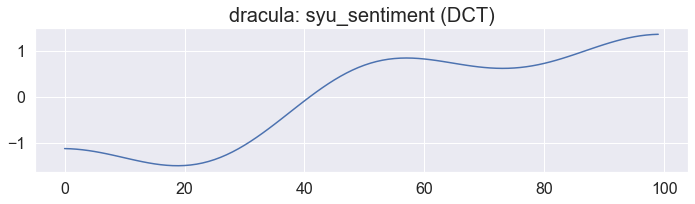

In [147]:
visualize_single('dracula', 'syu_sentiment')

**Sparknotes**:

> Dracula's ending resolves the major conflict of the plot by showing good triumphing over evil, and eliminating the threat Dracula has posed. The ending shows that a collective effort was necessary to defeat Dracula, and also that sacrifice was required. Morris gives up his life, but he is happy to do so.\
https://www.sparknotes.com/lit/dracula/what-does-the-ending-mean/